# Shap Regression

C:\Users\Retro\anaconda3\envs\boruta_test1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


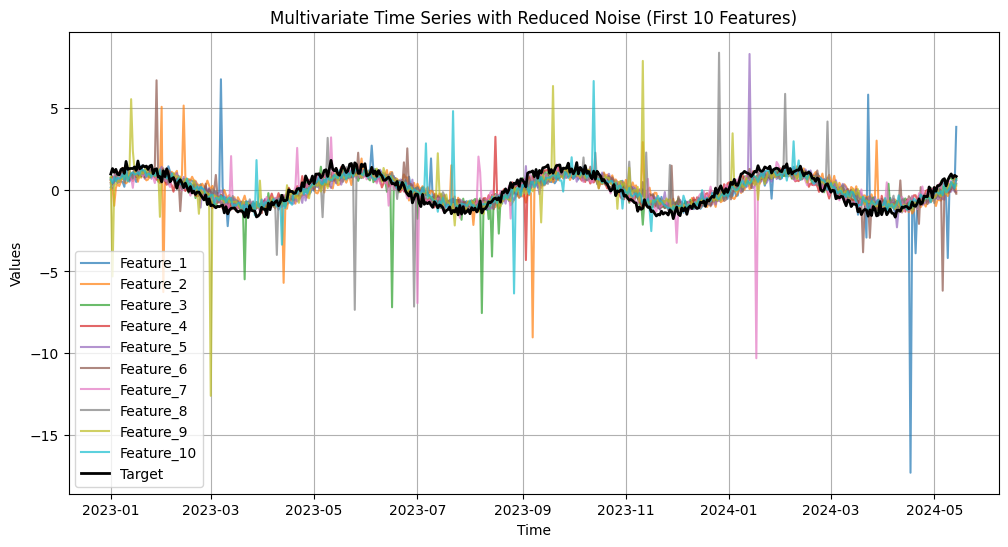

        Feature_1   Feature_2   Feature_3   Feature_4   Feature_5   Feature_6  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean    -0.001768   -0.002879   -0.052369    0.000588   -0.000236    0.006504   
std      1.202107    1.001437    0.941367    0.778977    0.828937    0.880674   
min    -17.297578   -9.027170   -7.540439   -4.301966   -2.299624   -6.172879   
25%     -0.702682   -0.665148   -0.677157   -0.691031   -0.710369   -0.676456   
50%      0.035125    0.039162   -0.034376    0.029191   -0.000897    0.034663   
75%      0.690931    0.711503    0.697301    0.714708    0.654448    0.677416   
max      6.747122    5.141107    1.591097    3.232740    8.292931    6.684712   

        Feature_7   Feature_8   Feature_9  Feature_10  Feature_11  Feature_12  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean    -0.020048    0.008036   -0.009845    0.011829   -0.012909   -0.005853   
std      0.961007    1.0417

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from BorutaShap import BorutaShap
from xgboost import XGBClassifier,XGBRegressor

# Function to add small shocks and occasional outliers
def add_shocks_and_outliers(data, shock_probability=0.02, outlier_probability=0.01, seed=42):
    np.random.seed(seed)
    data_with_noise = data.copy()
    for col in data_with_noise.columns:
        # Add small shocks
        shocks = np.random.binomial(1, shock_probability, size=data_with_noise[col].shape)
        data_with_noise[col] += shocks * np.random.normal(0, 2, size=data_with_noise[col].shape)
        
        # Add occasional outliers
        outliers = np.random.binomial(1, outlier_probability, size=data_with_noise[col].shape)
        data_with_noise[col] += outliers * np.random.normal(0, 6, size=data_with_noise[col].shape)
    
    return data_with_noise

# Function to generate multivariate time series with reduced noise
def generate_noisy_timeseries(n_samples=500, n_features=15, seed=42):
    np.random.seed(seed)
    time = pd.date_range(start="2023-01-01", periods=n_samples, freq="D")
    
    # Generate features with mild randomness
    features = {
        f"Feature_{i+1}": np.sin(0.05 * np.arange(n_samples) + np.random.rand()) 
        + np.random.randn(n_samples) * 0.2
        for i in range(n_features)
    }
    
    # Add a target variable loosely related to a few features
    y = (
        0.3 * features["Feature_1"]
        - 0.2 * features["Feature_5"]
        + 0.3 * features["Feature_7"]
        + 0.5 * features["Feature_11"]
        + 0.5 * features["Feature_3"]
        + 0.1 * np.random.randn(n_samples)
    )
    
    df = pd.DataFrame(features, index=time)
    df["Target"] = y
    df.index.name = "Time"
    
    # Add mild shocks and occasional outliers to the features
    df_with_noise = add_shocks_and_outliers(df.drop(columns=["Target"]))
    df_with_noise["Target"] = y  # Retain the target variable as-is
    
    return df_with_noise

# Generate the dataset
df_noisy = generate_noisy_timeseries()

# Visualize a subset of features and the target variable
def visualize_timeseries(df, features=None, target="Target", figsize=(12, 6), num_features=5):
    features = features or df.columns.drop(target).tolist()[:num_features]
    plt.figure(figsize=figsize)
    
    # Plot the selected features
    for feature in features:
        plt.plot(df.index, df[feature], label=feature, alpha=0.7)
    
    # Highlight the target variable
    if target in df.columns:
        plt.plot(df.index, df[target], label=target, color="black", linewidth=2)
    
    plt.title(f"Multivariate Time Series with Reduced Noise (First {num_features} Features)")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize the first few features and the target
visualize_timeseries(df_noisy, num_features=10)

# Check basic statistics
print(df_noisy.describe())

In [2]:
from BorutaShap import BorutaShap


In [3]:

X = df_noisy[[x for x in df_noisy.columns if x != 'Target']]
y = df_noisy['Target']

In [4]:
# no model selected default is Random Forest, if classification is False it is a Regression problem
model = XGBRegressor()

Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=X, y=y, n_trials=10, random_state=42, ordered_timeseries = True, test_size = .3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]

9 attributes confirmed important: ['Feature_4', 'Feature_11', 'Feature_13', 'Feature_12', 'Feature_7', 'Feature_15', 'Feature_5', 'Feature_1', 'Feature_3']
2 attributes confirmed unimportant: ['Feature_9', 'Feature_8']
4 tentative attributes remains: ['Feature_14', 'Feature_6', 'Feature_2', 'Feature_10']


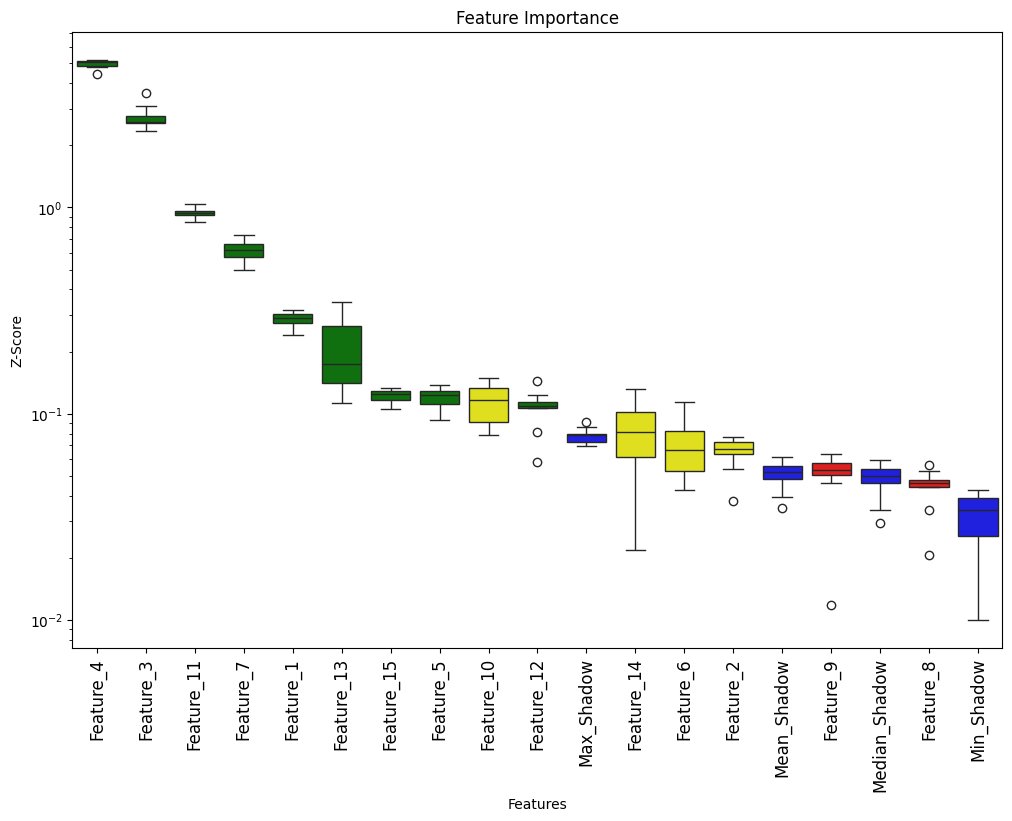

In [5]:
# Returns Boxplot of features
# I would recommend plotting Y axis on the Log Scale
Feature_Selector.plot(X_size=12, figsize=(12,8),
            y_scale='log', which_features='all')